# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_mag"],
    "x_transforms_target": ["unit_mag"],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_mag']
x_transforms_target ['unit_mag']
Average magnitude, source: 1.0
Average power, source: 1.2061379


Average magnitude, target: 1.0
Average power, target: 1.2297013


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1981.5218, train_label_loss: 4.7165, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3965.1172, train_label_loss: 4.1309, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4054.6569, train_label_loss: 3.5091, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4049.0899, train_label_loss: 2.8252, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4067.8456, train_label_loss: 2.4996, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3987.9538, train_label_loss: 2.1163, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4044.1629, train_label_loss: 2.0030, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4059.9645, train_label_loss: 1.6726, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4096.1280, train_label_loss: 1.6684, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4152.5485, train_label_loss: 1.4253, 


epoch: 1, source_val_acc_label: 0.7500, target_val_acc_label: 0.7395, source_val_label_loss: 1.3930, target_val_label_loss: 1.5140, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 497.8509, train_label_loss: 1.2419, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3995.4446, train_label_loss: 1.1954, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4141.2671, train_label_loss: 1.2619, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4141.5609, train_label_loss: 1.2347, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4136.1937, train_label_loss: 0.9540, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4063.3734, train_label_loss: 0.9887, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4142.0536, train_label_loss: 1.0184, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4123.8808, train_label_loss: 0.9474, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4177.7972, train_label_loss: 1.0611, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4225.9744, train_label_loss: 0.9164, 


epoch: 2, source_val_acc_label: 0.8295, target_val_acc_label: 0.7964, source_val_label_loss: 0.9126, target_val_label_loss: 1.1450, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 490.7402, train_label_loss: 0.8419, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4025.2497, train_label_loss: 0.8364, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4129.4541, train_label_loss: 0.7422, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4131.7681, train_label_loss: 0.6781, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4131.8996, train_label_loss: 0.5957, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4046.8108, train_label_loss: 0.6826, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4127.4973, train_label_loss: 0.7354, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4123.1028, train_label_loss: 0.7914, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4152.7332, train_label_loss: 0.5116, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4233.3616, train_label_loss: 0.6139, 


epoch: 3, source_val_acc_label: 0.8788, target_val_acc_label: 0.8192, source_val_label_loss: 0.6545, target_val_label_loss: 0.9725, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 492.0815, train_label_loss: 0.4420, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4035.7995, train_label_loss: 0.5796, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4133.8590, train_label_loss: 0.4304, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4127.8169, train_label_loss: 0.7186, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4133.0710, train_label_loss: 0.4967, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4057.2706, train_label_loss: 0.4591, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4136.0650, train_label_loss: 0.3103, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4130.5333, train_label_loss: 0.4133, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4167.8440, train_label_loss: 0.3637, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4224.2147, train_label_loss: 0.3621, 


epoch: 4, source_val_acc_label: 0.9096, target_val_acc_label: 0.8376, source_val_label_loss: 0.5034, target_val_label_loss: 0.9112, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 490.3610, train_label_loss: 0.2880, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4036.3328, train_label_loss: 0.3840, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4121.5086, train_label_loss: 0.4215, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4122.0888, train_label_loss: 0.4159, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4109.9210, train_label_loss: 0.3160, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4045.0780, train_label_loss: 0.4981, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4102.3977, train_label_loss: 0.3082, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4126.9381, train_label_loss: 0.3293, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4163.6315, train_label_loss: 0.3907, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4227.8963, train_label_loss: 0.3149, 


epoch: 5, source_val_acc_label: 0.9212, target_val_acc_label: 0.8459, source_val_label_loss: 0.4148, target_val_label_loss: 0.8385, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 491.7741, train_label_loss: 0.3818, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4034.9961, train_label_loss: 0.1713, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4135.4486, train_label_loss: 0.1484, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4138.4979, train_label_loss: 0.4527, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4131.2735, train_label_loss: 0.1023, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4060.5713, train_label_loss: 0.2491, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4128.3207, train_label_loss: 0.3297, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4139.6275, train_label_loss: 0.2196, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4164.0232, train_label_loss: 0.4309, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4225.0281, train_label_loss: 0.2625, 


epoch: 6, source_val_acc_label: 0.9429, target_val_acc_label: 0.8583, source_val_label_loss: 0.3481, target_val_label_loss: 0.7819, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 489.8760, train_label_loss: 0.4182, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4021.6203, train_label_loss: 0.1986, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4133.6193, train_label_loss: 0.2483, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4121.5080, train_label_loss: 0.2829, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4127.1239, train_label_loss: 0.1753, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4047.2890, train_label_loss: 0.2207, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4127.6301, train_label_loss: 0.3488, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4130.2564, train_label_loss: 0.2476, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4158.6865, train_label_loss: 0.2829, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4223.5946, train_label_loss: 0.2476, 


epoch: 7, source_val_acc_label: 0.9455, target_val_acc_label: 0.8647, source_val_label_loss: 0.3284, target_val_label_loss: 0.7529, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 490.9745, train_label_loss: 0.2789, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4016.3474, train_label_loss: 0.1806, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4130.3206, train_label_loss: 0.2220, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4123.9457, train_label_loss: 0.1702, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4117.5046, train_label_loss: 0.2786, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4043.2818, train_label_loss: 0.1528, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4131.5818, train_label_loss: 0.1583, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4121.6115, train_label_loss: 0.1378, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4162.4961, train_label_loss: 0.1158, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4220.9136, train_label_loss: 0.1427, 


epoch: 8, source_val_acc_label: 0.9513, target_val_acc_label: 0.8650, source_val_label_loss: 0.3048, target_val_label_loss: 0.7327, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 491.8416, train_label_loss: 0.1289, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4026.0670, train_label_loss: 0.1198, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4123.3241, train_label_loss: 0.1915, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4129.5501, train_label_loss: 0.2497, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4123.5331, train_label_loss: 0.0978, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4052.1255, train_label_loss: 0.2435, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4131.0857, train_label_loss: 0.2107, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4120.5416, train_label_loss: 0.2397, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4160.0622, train_label_loss: 0.2368, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4217.2344, train_label_loss: 0.1160, 


epoch: 9, source_val_acc_label: 0.9506, target_val_acc_label: 0.8673, source_val_label_loss: 0.3013, target_val_label_loss: 0.7302, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 491.7394, train_label_loss: 0.1875, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4016.8740, train_label_loss: 0.1223, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4119.5516, train_label_loss: 0.2203, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4118.4597, train_label_loss: 0.2061, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4112.8971, train_label_loss: 0.1405, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4041.4693, train_label_loss: 0.2069, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4122.9749, train_label_loss: 0.2998, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4111.1063, train_label_loss: 0.1555, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4153.7468, train_label_loss: 0.1777, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4214.9850, train_label_loss: 0.0726, 


epoch: 10, source_val_acc_label: 0.9532, target_val_acc_label: 0.8752, source_val_label_loss: 0.2884, target_val_label_loss: 0.7070, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 488.8964, train_label_loss: 0.0683, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4004.8176, train_label_loss: 0.1982, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4111.3171, train_label_loss: 0.1054, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4107.2258, train_label_loss: 0.1627, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4109.2411, train_label_loss: 0.1747, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4028.8818, train_label_loss: 0.1056, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4116.3825, train_label_loss: 0.0669, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4117.3647, train_label_loss: 0.1620, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4150.0454, train_label_loss: 0.1679, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4213.8205, train_label_loss: 0.0771, 


epoch: 11, source_val_acc_label: 0.9558, target_val_acc_label: 0.8703, source_val_label_loss: 0.2795, target_val_label_loss: 0.7339, 


epoch: 12, [batch: 1 / 45], examples_per_second: 504.1319, train_label_loss: 0.1266, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4020.3482, train_label_loss: 0.1132, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4115.0264, train_label_loss: 0.1470, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4116.5046, train_label_loss: 0.1854, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4129.3290, train_label_loss: 0.1599, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4041.2141, train_label_loss: 0.1358, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4123.9541, train_label_loss: 0.1996, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4114.6786, train_label_loss: 0.1387, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4149.3354, train_label_loss: 0.1444, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4220.1328, train_label_loss: 0.2071, 


epoch: 12, source_val_acc_label: 0.9558, target_val_acc_label: 0.8769, source_val_label_loss: 0.2828, target_val_label_loss: 0.7003, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 487.6536, train_label_loss: 0.1164, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4014.6470, train_label_loss: 0.1276, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4120.4481, train_label_loss: 0.0649, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4115.0879, train_label_loss: 0.1719, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4107.4705, train_label_loss: 0.1407, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4039.6417, train_label_loss: 0.2242, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4118.2199, train_label_loss: 0.1714, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4115.7346, train_label_loss: 0.1034, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4148.3795, train_label_loss: 0.1169, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4205.9577, train_label_loss: 0.2185, 


epoch: 13, source_val_acc_label: 0.9551, target_val_acc_label: 0.8739, source_val_label_loss: 0.2852, target_val_label_loss: 0.7221, 


epoch: 14, [batch: 1 / 45], examples_per_second: 501.7471, train_label_loss: 0.0523, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4021.4779, train_label_loss: 0.0603, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4109.5230, train_label_loss: 0.2703, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4133.9647, train_label_loss: 0.1353, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4118.4205, train_label_loss: 0.1748, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4051.7678, train_label_loss: 0.1178, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4125.1506, train_label_loss: 0.0749, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4126.4868, train_label_loss: 0.0824, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4162.4796, train_label_loss: 0.1128, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4210.4316, train_label_loss: 0.1824, 


epoch: 14, source_val_acc_label: 0.9564, target_val_acc_label: 0.8737, source_val_label_loss: 0.2818, target_val_label_loss: 0.7200, 


epoch: 15, [batch: 1 / 45], examples_per_second: 502.8367, train_label_loss: 0.1200, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4022.3397, train_label_loss: 0.0808, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4105.1311, train_label_loss: 0.1029, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4112.0925, train_label_loss: 0.0451, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4112.8723, train_label_loss: 0.1839, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4022.7540, train_label_loss: 0.0649, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4121.8498, train_label_loss: 0.0999, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4109.8126, train_label_loss: 0.0672, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4155.5614, train_label_loss: 0.0760, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4221.2747, train_label_loss: 0.2137, 


epoch: 15, source_val_acc_label: 0.9551, target_val_acc_label: 0.8754, source_val_label_loss: 0.2876, target_val_label_loss: 0.7135, 


epoch: 16, [batch: 1 / 45], examples_per_second: 506.0129, train_label_loss: 0.0765, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4034.2438, train_label_loss: 0.0680, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4127.6363, train_label_loss: 0.0814, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4123.1012, train_label_loss: 0.1195, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4122.3858, train_label_loss: 0.1729, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4049.9537, train_label_loss: 0.1380, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4125.9591, train_label_loss: 0.1572, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4137.0127, train_label_loss: 0.1051, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4151.6986, train_label_loss: 0.1509, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4212.6680, train_label_loss: 0.1096, 


epoch: 16, source_val_acc_label: 0.9564, target_val_acc_label: 0.8803, source_val_label_loss: 0.2651, target_val_label_loss: 0.6872, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 491.2813, train_label_loss: 0.1586, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4010.8537, train_label_loss: 0.1320, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4108.7813, train_label_loss: 0.0826, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4096.9799, train_label_loss: 0.2148, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4123.1870, train_label_loss: 0.0796, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4043.7412, train_label_loss: 0.1813, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4116.6155, train_label_loss: 0.0752, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4124.3222, train_label_loss: 0.0617, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4149.6070, train_label_loss: 0.0831, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4217.6976, train_label_loss: 0.1520, 


epoch: 17, source_val_acc_label: 0.9551, target_val_acc_label: 0.8771, source_val_label_loss: 0.2688, target_val_label_loss: 0.7057, 


epoch: 18, [batch: 1 / 45], examples_per_second: 507.8769, train_label_loss: 0.0845, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4025.4622, train_label_loss: 0.1253, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4122.9516, train_label_loss: 0.1843, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4130.4711, train_label_loss: 0.1130, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4127.5301, train_label_loss: 0.0916, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4056.6742, train_label_loss: 0.1707, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4131.9622, train_label_loss: 0.1113, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4130.5458, train_label_loss: 0.0908, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4164.0627, train_label_loss: 0.1523, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4217.4350, train_label_loss: 0.1047, 


epoch: 18, source_val_acc_label: 0.9551, target_val_acc_label: 0.8799, source_val_label_loss: 0.2703, target_val_label_loss: 0.6840, 


epoch: 19, [batch: 1 / 45], examples_per_second: 508.8078, train_label_loss: 0.0622, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4024.4624, train_label_loss: 0.1465, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4116.5922, train_label_loss: 0.0904, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4117.2121, train_label_loss: 0.1029, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4123.5502, train_label_loss: 0.0576, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4040.9146, train_label_loss: 0.0603, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4124.9712, train_label_loss: 0.1183, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4114.2067, train_label_loss: 0.0741, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4152.1969, train_label_loss: 0.0253, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4210.5405, train_label_loss: 0.1523, 


epoch: 19, source_val_acc_label: 0.9622, target_val_acc_label: 0.8810, source_val_label_loss: 0.2566, target_val_label_loss: 0.6914, 


New best


epoch: 20, [batch: 1 / 45], examples_per_second: 491.1279, train_label_loss: 0.1099, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4010.9378, train_label_loss: 0.0969, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4125.6953, train_label_loss: 0.1006, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4119.5089, train_label_loss: 0.0872, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4120.6007, train_label_loss: 0.0608, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4045.9760, train_label_loss: 0.1616, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4125.8108, train_label_loss: 0.0620, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4132.2441, train_label_loss: 0.1343, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4158.3959, train_label_loss: 0.1415, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4205.1614, train_label_loss: 0.0898, 


epoch: 20, source_val_acc_label: 0.9577, target_val_acc_label: 0.8806, source_val_label_loss: 0.2727, target_val_label_loss: 0.7064, 


epoch: 21, [batch: 1 / 45], examples_per_second: 504.6264, train_label_loss: 0.1842, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4009.5560, train_label_loss: 0.0908, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4112.1263, train_label_loss: 0.1171, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4106.3671, train_label_loss: 0.0383, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4117.2559, train_label_loss: 0.0769, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4044.0135, train_label_loss: 0.0511, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4121.7579, train_label_loss: 0.0677, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4112.3326, train_label_loss: 0.0343, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4146.8286, train_label_loss: 0.0570, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4217.0762, train_label_loss: 0.0903, 


epoch: 21, source_val_acc_label: 0.9564, target_val_acc_label: 0.8846, source_val_label_loss: 0.2777, target_val_label_loss: 0.6795, 


New best


epoch: 22, [batch: 1 / 45], examples_per_second: 486.3500, train_label_loss: 0.0650, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4026.8386, train_label_loss: 0.0235, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4121.4837, train_label_loss: 0.0669, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4121.6950, train_label_loss: 0.0378, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4119.5578, train_label_loss: 0.0479, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4046.8072, train_label_loss: 0.1160, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4112.2659, train_label_loss: 0.1160, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4122.9204, train_label_loss: 0.0227, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4157.5107, train_label_loss: 0.0292, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4216.6881, train_label_loss: 0.1443, 


epoch: 22, source_val_acc_label: 0.9571, target_val_acc_label: 0.8831, source_val_label_loss: 0.2757, target_val_label_loss: 0.6850, 


epoch: 23, [batch: 1 / 45], examples_per_second: 503.9554, train_label_loss: 0.0638, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4015.2871, train_label_loss: 0.0811, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4115.9878, train_label_loss: 0.0470, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4110.5772, train_label_loss: 0.0766, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4113.7660, train_label_loss: 0.0149, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4028.1151, train_label_loss: 0.0362, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4097.0403, train_label_loss: 0.1720, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4108.2272, train_label_loss: 0.0804, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4149.7662, train_label_loss: 0.1014, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4210.4137, train_label_loss: 0.0755, 


epoch: 23, source_val_acc_label: 0.9558, target_val_acc_label: 0.8878, source_val_label_loss: 0.2736, target_val_label_loss: 0.6603, 


New best


epoch: 24, [batch: 1 / 45], examples_per_second: 492.7890, train_label_loss: 0.0217, 


epoch: 24, [batch: 5 / 45], examples_per_second: 4027.2833, train_label_loss: 0.0704, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4119.9251, train_label_loss: 0.0629, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4113.7206, train_label_loss: 0.1044, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4123.5643, train_label_loss: 0.1413, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4050.5578, train_label_loss: 0.0570, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4129.8153, train_label_loss: 0.0235, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4123.9744, train_label_loss: 0.0541, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4165.5158, train_label_loss: 0.1533, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4212.9023, train_label_loss: 0.1528, 


epoch: 24, source_val_acc_label: 0.9577, target_val_acc_label: 0.8872, source_val_label_loss: 0.2763, target_val_label_loss: 0.6789, 


epoch: 25, [batch: 1 / 45], examples_per_second: 503.1018, train_label_loss: 0.0872, 


epoch: 25, [batch: 5 / 45], examples_per_second: 4016.6832, train_label_loss: 0.0998, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4113.0383, train_label_loss: 0.1184, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4119.5463, train_label_loss: 0.0586, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4116.3157, train_label_loss: 0.0811, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4028.6425, train_label_loss: 0.0430, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4114.1959, train_label_loss: 0.0232, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4127.3676, train_label_loss: 0.0988, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4163.4153, train_label_loss: 0.0813, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4220.9349, train_label_loss: 0.0519, 


epoch: 25, source_val_acc_label: 0.9615, target_val_acc_label: 0.8874, source_val_label_loss: 0.2686, target_val_label_loss: 0.6653, 


epoch: 26, [batch: 1 / 45], examples_per_second: 502.7200, train_label_loss: 0.0148, 


epoch: 26, [batch: 5 / 45], examples_per_second: 4016.2438, train_label_loss: 0.0462, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4118.0037, train_label_loss: 0.1309, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4120.9685, train_label_loss: 0.0711, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4113.5797, train_label_loss: 0.0847, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4047.5053, train_label_loss: 0.1678, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4119.4862, train_label_loss: 0.0993, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4124.0742, train_label_loss: 0.0551, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4151.8124, train_label_loss: 0.0937, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4221.8647, train_label_loss: 0.0540, 


epoch: 26, source_val_acc_label: 0.9583, target_val_acc_label: 0.8887, source_val_label_loss: 0.2706, target_val_label_loss: 0.6653, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 491.7650, train_label_loss: 0.0831, 


epoch: 27, [batch: 5 / 45], examples_per_second: 4023.8729, train_label_loss: 0.1321, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4117.3740, train_label_loss: 0.0407, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4129.8041, train_label_loss: 0.0427, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4113.8855, train_label_loss: 0.0313, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4056.0368, train_label_loss: 0.1073, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4122.9547, train_label_loss: 0.0220, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4124.9306, train_label_loss: 0.1479, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4158.8387, train_label_loss: 0.0627, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4220.5983, train_label_loss: 0.0546, 


epoch: 27, source_val_acc_label: 0.9590, target_val_acc_label: 0.8840, source_val_label_loss: 0.2619, target_val_label_loss: 0.6852, 


epoch: 28, [batch: 1 / 45], examples_per_second: 506.0968, train_label_loss: 0.0620, 


epoch: 28, [batch: 5 / 45], examples_per_second: 4009.1860, train_label_loss: 0.0906, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4112.0085, train_label_loss: 0.0171, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4121.3361, train_label_loss: 0.0704, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4108.1699, train_label_loss: 0.0826, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4030.7963, train_label_loss: 0.0487, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4095.1233, train_label_loss: 0.0232, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4112.6458, train_label_loss: 0.0349, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4147.3156, train_label_loss: 0.0576, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4219.9516, train_label_loss: 0.0628, 


epoch: 28, source_val_acc_label: 0.9545, target_val_acc_label: 0.8825, source_val_label_loss: 0.2951, target_val_label_loss: 0.7082, 


epoch: 29, [batch: 1 / 45], examples_per_second: 503.9941, train_label_loss: 0.0973, 


epoch: 29, [batch: 5 / 45], examples_per_second: 4023.5121, train_label_loss: 0.1143, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4101.6401, train_label_loss: 0.0758, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4099.7400, train_label_loss: 0.0378, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4111.5279, train_label_loss: 0.0581, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4037.4198, train_label_loss: 0.1253, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4116.7368, train_label_loss: 0.0950, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4109.7816, train_label_loss: 0.1430, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4134.7433, train_label_loss: 0.0424, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4210.1276, train_label_loss: 0.1428, 


epoch: 29, source_val_acc_label: 0.9558, target_val_acc_label: 0.8806, source_val_label_loss: 0.2773, target_val_label_loss: 0.6882, 


epoch: 30, [batch: 1 / 45], examples_per_second: 504.4737, train_label_loss: 0.1052, 


epoch: 30, [batch: 5 / 45], examples_per_second: 4023.2048, train_label_loss: 0.0881, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4127.9472, train_label_loss: 0.0689, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4123.5465, train_label_loss: 0.1004, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4127.6551, train_label_loss: 0.0804, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4044.3495, train_label_loss: 0.0672, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4123.6188, train_label_loss: 0.0717, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4125.1459, train_label_loss: 0.1113, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4159.8159, train_label_loss: 0.0953, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4215.0762, train_label_loss: 0.1152, 


epoch: 30, source_val_acc_label: 0.9596, target_val_acc_label: 0.8853, source_val_label_loss: 0.2834, target_val_label_loss: 0.6883, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

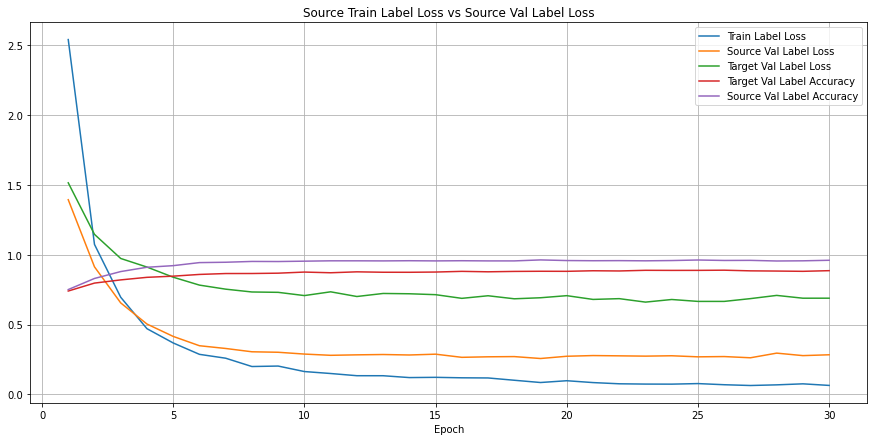

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

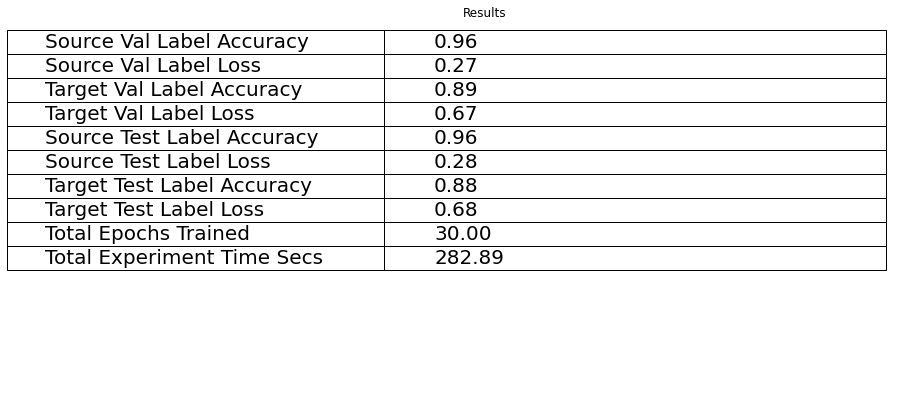

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

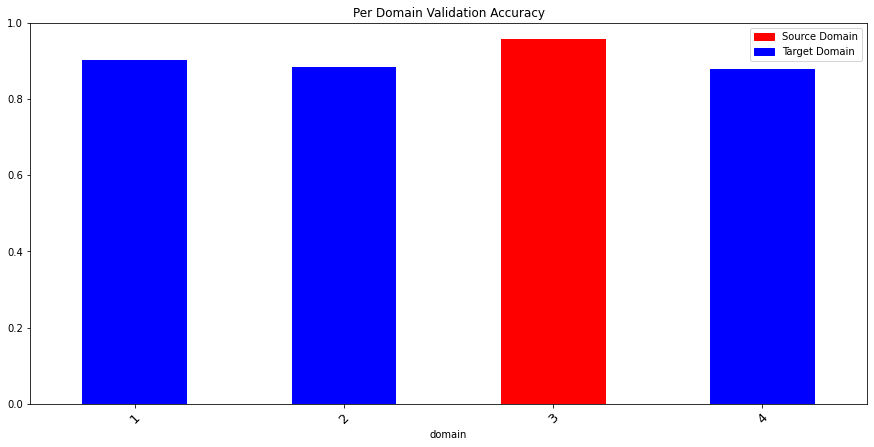

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9564102564102565 Target Test Label Accuracy: 0.8844017094017094
Source Val Label Accuracy: 0.9583333333333334 Target Val Label Accuracy: 0.8886752136752136


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "